# Network parameters

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
N_BATCH=32
EPOCHS=100
PATIENCE=10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=PATIENCE)

# Load libraries

In [3]:
import cnn_models
import data_preparation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.svm import SVC
import data_augmentation
import random
from sklearn.preprocessing import StandardScaler

/Users/kappa/opt/miniconda3/envs/dsim/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/kappa/opt/miniconda3/envs/dsim/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# Set seed for reproducibility

In [4]:
SEED = 10
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED)

# Load dataset
## No augmentation

In [5]:
fsdd_dir="./recordings/"
our_recs_dir="./preprocessed_recs/"

In [6]:
recordings = data_preparation.load_recordings(paths=[fsdd_dir, our_recs_dir])

Loading from ./recordings/



Loading from ./preprocessed_recs/


How much does input recordings vary?

In [7]:
min_y = min(map(np.shape, recordings))[0]
max_y = max(map(np.shape, recordings))[0]
print(min_y, max_y)

1010 18262


It's quite a huge difference! Let's find out the 10 longest recordings:

In [8]:
a = [len(x) for x in recordings]
a.sort(reverse=True)
a[0:10]

[18262, 17567, 9015, 8995, 8435, 8281, 8201, 8068, 7755, 7356]

Let's now get their indexes:

In [9]:
a = [len(x) for x in recordings]
first_length=18262
second_length=17567
index_first = a.index(first_length)
index_second = a.index(second_length)

In [10]:
labels_speakers = data_preparation.load_labels(paths=[fsdd_dir, our_recs_dir], label_type="speakers")
labels_digits = data_preparation.load_labels(paths=[fsdd_dir, our_recs_dir])
print("Longest track is associated with speaker {}, digit {}".format(labels_speakers[index_first],labels_digits[index_first]))
print("Second longest track is associated with speaker {}, digit {}".format(labels_speakers[index_second],labels_digits[index_second]))

Longest track is associated with speaker theo, digit 9
Second longest track is associated with speaker theo, digit 7


So the problem is with theo, which has 500 recordings, digit 9 and 7, which respectively have 200 recordings. We can safely delete them and saving to pad many thousands of 0s (there will be (18262 - 9015) less zeros)

In [11]:
max_track_length=9015 # it will be useful later on
print("Before: {}".format(len(recordings)))
recordings=np.delete(recordings,[index_first, index_second])
print("After: {}".format(len(recordings)))

Before: 2400
After: 2398


In [12]:
print("Before: {}".format(len(labels_speakers)))
labels_speakers=np.delete(labels_speakers,[index_first, index_second])
print("After: {}".format(len(labels_speakers)))

Before: 2400
After: 2398


In [13]:
print("Before: {}".format(len(labels_digits)))
labels_digits=np.delete(labels_digits,[index_first, index_second])
print("After: {}".format(len(labels_digits)))

Before: 2400
After: 2398


Let's now double check to see if everything went well. Now the longest recording will be around 9 K

In [14]:
a = [len(x) for x in recordings]
a.sort(reverse=True)
a[0:10]

[9015, 8995, 8435, 8281, 8201, 8068, 7755, 7356, 7147, 7038]

Even though variability is reduced, it is still there: for this reason we will pad zeros at start and end of recordings

In [15]:
pad_recordings = data_preparation.pad_zeros(recordings)

Now they will have the same length:

In [16]:
min_y = min(map(np.shape, pad_recordings))[0]
max_y = max(map(np.shape, pad_recordings))[0]
print(min_y, max_y)

9015 9015


Now we will create balancede train, validation and test sets. For digits it's not a huge problem (only 7 and 9, because of the previous operation, have 1 recordings less, however our 4 speakers (ale, alinda, gian, khaled) have 100 recordings, while the other 4 have 500 recordings.

In [17]:
X, y = data_preparation.balanced_train_val_test_split(pad_recordings, labels_digits)
X_train_digits = X[0]
y_train_digits = y[0]
X_val_digits = X[1]
y_val_digits = y[1] 
X_test_digits = X[2]
y_test_digits = y[2] 

In [18]:
X, y = data_preparation.balanced_train_val_test_split(pad_recordings, labels_speakers)
X_train_speakers = X[0]
y_train_speakers = y[0]
X_val_speakers = X[1]
y_val_speakers = y[1] 
X_test_speakers = X[2]
y_test_speakers = y[2] 

# Digits
## Spectrograms - No augmentation

In [19]:
%%time
X_train_digits_spects = np.array([data_preparation.compute_spectrogram(x) for x in X_train_digits])
X_val_digits_spects = np.array([data_preparation.compute_spectrogram(x) for x in X_val_digits])
X_test_digits_spects = np.array([data_preparation.compute_spectrogram(x) for x in X_test_digits])

CPU times: user 23.3 s, sys: 393 ms, total: 23.6 s
Wall time: 14.7 s


In [20]:
%%time
X_train_digits_spects_norm = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_train_digits])
X_val_digits_spects_norm = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_val_digits])
X_test_digits_spects_norm = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_test_digits])

CPU times: user 23.1 s, sys: 351 ms, total: 23.5 s
Wall time: 13.5 s


In [21]:
nsamples, nx, ny = X_train_digits_spects.shape
X_train_digits_spects_2d = X_train_digits_spects.reshape((nsamples, nx * ny))

In [22]:
%%time
clf1 = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf1 = clf1.fit(X_train_digits_spects_2d, y_train_digits)

CPU times: user 8.75 s, sys: 67.3 ms, total: 8.81 s
Wall time: 9.02 s


In [23]:
nsamples, nx, ny = X_val_digits_spects.shape
X_val_digits_spects_2d = X_val_digits_spects.reshape((nsamples, nx * ny))

In [24]:
%%time
y_pred = clf1.predict(X_val_digits_spects_2d)
print(classification_report(y_val_digits, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        48
           1       0.69      0.23      0.34        48
           2       0.62      0.17      0.26        48
           3       0.56      0.19      0.28        48
           4       0.13      0.50      0.21        48
           5       0.64      0.19      0.29        48
           6       0.13      0.52      0.20        48
           7       0.70      0.15      0.24        48
           8       0.80      0.08      0.15        48
           9       0.93      0.27      0.42        48

    accuracy                           0.25       480
   macro avg       0.62      0.25      0.27       480
weighted avg       0.62      0.25      0.27       480

CPU times: user 1.75 s, sys: 18.7 ms, total: 1.77 s
Wall time: 1.88 s


Normalized spectrograms

In [25]:
nsamples, nx, ny = X_train_digits_spects_norm.shape
X_train_digits_spects_norm_2d = X_train_digits_spects_norm.reshape((nsamples, nx * ny))

In [26]:
%%time
clf = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf = clf.fit(X_train_digits_spects_norm_2d, y_train_digits)

CPU times: user 4.11 s, sys: 32.9 ms, total: 4.14 s
Wall time: 4.28 s


In [27]:
nsamples, nx, ny = X_val_digits_spects_norm.shape
X_val_digits_spects_norm_2d = X_val_digits_spects_norm.reshape((nsamples, nx * ny))

In [28]:
%%time
y_pred = clf.predict(X_val_digits_spects_norm_2d)
print(classification_report(y_val_digits, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.90      0.90      0.90        48
           2       0.87      0.94      0.90        48
           3       0.96      0.90      0.92        48
           4       1.00      0.85      0.92        48
           5       0.93      0.88      0.90        48
           6       0.85      0.92      0.88        48
           7       0.87      0.98      0.92        48
           8       0.90      0.90      0.90        48
           9       0.91      0.85      0.88        48

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480

CPU times: user 1.52 s, sys: 16.9 ms, total: 1.54 s
Wall time: 1.68 s


Normalized spectrograms lead to better performances, therefore let's use this representation as default
### CNN

In [29]:
X_data, y_data, input_shape, _ = data_preparation.prepare_data_nn(X_train_digits_spects_norm, X_val_digits_spects_norm, X_test_digits_spects_norm, y_train_digits, y_val_digits, y_test_digits, number_mode=True)

X_train_digits_spects_norm_nn  = X_data[0]
y_train_digits_nn = y_data[0]
X_val_digits_spects_norm_nn  = X_data[1]
y_val_digits_nn = y_data[1]
X_test_digits_spects_norm_nn = X_data[2]
y_test_digits_nn  = y_data[2]


In [30]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=10)
model.fit(X_train_digits_spects_norm_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_spects_norm_nn, y_val_digits_nn))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 17, 32)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 8, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16128)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1032256   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 1,033,066
Trainable params: 1,033,066
Non-trainable params: 0
______________________________________________

In [31]:
y_nn = np.argmax(y_val_digits_nn, axis=1)
y_pred = model.predict_classes(X_val_digits_spects_norm_nn)
print(classification_report(y_nn, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        48
           1       0.87      1.00      0.93        48
           2       0.96      0.94      0.95        48
           3       0.94      0.94      0.94        48
           4       0.98      0.96      0.97        48
           5       1.00      0.94      0.97        48
           6       0.88      0.94      0.91        48
           7       0.98      0.98      0.98        48
           8       0.94      0.92      0.93        48
           9       0.95      0.83      0.89        48

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480



In [32]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=10, batch_normalisation=True)
model.fit(X_train_digits_spects_norm_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_spects_norm_nn, y_val_digits_nn))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 127, 17, 32)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 17, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 8, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1032256   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.2689 - val_accuracy: 0.9604
Epoch 47/100
1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.2740 - val_accuracy: 0.9563
Epoch 48/100
1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.2665 - val_accuracy: 0.9604
Epoch 49/100
1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.2675 - val_accuracy: 0.9583
Epoch 50/100
1430/1430 [==============================] - 4s 2ms/sample - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.2705 - val_accuracy: 0.9583
Epoch 51/100
1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.2738 - val_accuracy: 0.9563
Epoch 52/100
1430/1430 [==============================] - 4s 2ms/sample - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.2685 

In [33]:
y_nn = np.argmax(y_val_digits_nn, axis=1)
y_pred = model.predict_classes(X_val_digits_spects_norm_nn)
print(classification_report(y_nn, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        48
           1       0.96      0.94      0.95        48
           2       0.96      0.94      0.95        48
           3       0.96      0.98      0.97        48
           4       1.00      0.96      0.98        48
           5       0.94      0.96      0.95        48
           6       0.94      0.96      0.95        48
           7       1.00      0.94      0.97        48
           8       0.98      1.00      0.99        48
           9       0.88      0.94      0.91        48

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



Let's now try with MFCCs
## MFCC - No augmentation

In [34]:
%%time
X_train_digits_mfcc= np.array([data_preparation.mfcc(x, flatten=True) for x in X_train_digits])
X_val_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_val_digits])
X_test_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_test_digits])

CPU times: user 22.4 s, sys: 353 ms, total: 22.8 s
Wall time: 11.9 s


In [35]:
%time
scaler_normal = StandardScaler()
X_train_digits_mfcc_scaled = scaler_normal.fit_transform(X_train_digits_mfcc)
X_val_digits_mfcc_scaled =  scaler_normal.transform(X_val_digits_mfcc)
X_test_digits_mfcc_scaled =  scaler_normal.transform(X_test_digits_mfcc)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


### SVC

In [36]:
%%time
clf = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf = clf.fit(X_train_digits_mfcc_scaled, y_train_digits)

CPU times: user 722 ms, sys: 12 ms, total: 734 ms
Wall time: 818 ms


In [37]:
%%time
y_pred = clf.predict(X_val_digits_mfcc_scaled)
print(classification_report(y_val_digits, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        48
           1       0.98      0.98      0.98        48
           2       1.00      1.00      1.00        48
           3       0.96      0.96      0.96        48
           4       1.00      0.88      0.93        48
           5       1.00      0.92      0.96        48
           6       0.69      0.92      0.79        48
           7       1.00      0.96      0.98        48
           8       0.92      0.94      0.93        48
           9       0.98      0.94      0.96        48

    accuracy                           0.94       480
   macro avg       0.95      0.94      0.94       480
weighted avg       0.95      0.94      0.94       480

CPU times: user 244 ms, sys: 5.28 ms, total: 249 ms
Wall time: 310 ms


Similar results of the best Spectrograms model. Let's now use CNNs with MFCC
### CNN

In [38]:
%%time
X_train_digits_mfcc= np.array([data_preparation.mfcc(x, flatten=False) for x in X_train_digits])
X_val_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_val_digits])
X_test_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_test_digits])

CPU times: user 22.6 s, sys: 360 ms, total: 22.9 s
Wall time: 12 s


In [39]:
X_train_digits_mfcc.shape

(1430, 20, 18)

In [40]:
X, y, input_shape, _= data_preparation.prepare_data_nn(X_train_digits_mfcc, X_val_digits_mfcc, X_test_digits_mfcc, y_train_digits, y_val_digits, y_test_digits, number_mode=True)

X_train_digits_mfcc_nn = X[0]
y_train_digits_nn = y[0]
X_val_digits_mfcc_nn = X[1]
y_val_digits_nn = y[1]
X_test_digits_mfcc_nn = X[2]
y_test_digits_nn = y[2]

In [41]:
input_shape

(20, 18, 1)

We can now start to train the models, let's start with the simpler one:

In [42]:
%%time
model = cnn_models.simple_model(input_shape=input_shape,
                                num_classes=10)
model.fit(X_train_digits_mfcc_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_mfcc_nn, y_val_digits_nn))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                147520    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 148,330
Trainable params: 148,330
Non-trainable params: 0
________________________________________________

1430/1430 [==============================] - 1s 636us/sample - loss: 2.3027 - accuracy: 0.0902 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 48/100
1430/1430 [==============================] - 1s 612us/sample - loss: 2.3027 - accuracy: 0.0790 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 49/100
1430/1430 [==============================] - 1s 589us/sample - loss: 2.3027 - accuracy: 0.0818 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 50/100
1430/1430 [==============================] - 1s 586us/sample - loss: 2.3027 - accuracy: 0.0930 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 51/100
1430/1430 [==============================] - 1s 600us/sample - loss: 2.3027 - accuracy: 0.0853 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 52/100
1430/1430 [==============================] - 1s 601us/sample - loss: 2.3027 - accuracy: 0.0937 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 53/100
1430/1430 [==============================] - 1s 603us/sample - loss: 2.3027 - accuracy: 0.0874 - val

In [43]:
Y_val_nn = np.argmax(y_val_digits_nn,  axis=1)
y_pred = model.predict_classes(X_val_digits_mfcc_nn)
print(classification_report(Y_val_nn, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        48
           8       0.10      1.00      0.18        48
           9       0.00      0.00      0.00        48

    accuracy                           0.10       480
   macro avg       0.01      0.10      0.02       480
weighted avg       0.01      0.10      0.02       480



/Users/kappa/opt/miniconda3/envs/dsim/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Really poor results, let's now use batch normalisation:

In [44]:
%%time
model = cnn_models.simple_model(input_shape=input_shape,
                                num_classes=10,
                                batch_normalisation=True)
model.fit(X_train_digits_mfcc_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_mfcc_nn, y_val_digits_nn))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                147520    
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

1430/1430 [==============================] - 1s 742us/sample - loss: 0.0459 - accuracy: 0.9972 - val_loss: 0.2176 - val_accuracy: 0.9479
Epoch 47/100
1430/1430 [==============================] - 1s 719us/sample - loss: 0.0414 - accuracy: 0.9930 - val_loss: 0.1988 - val_accuracy: 0.9521
Epoch 48/100
1430/1430 [==============================] - 1s 766us/sample - loss: 0.0409 - accuracy: 0.9944 - val_loss: 0.2124 - val_accuracy: 0.9500
Epoch 49/100
1430/1430 [==============================] - 1s 767us/sample - loss: 0.0429 - accuracy: 0.9965 - val_loss: 0.2060 - val_accuracy: 0.9500
Epoch 50/100
1430/1430 [==============================] - 1s 741us/sample - loss: 0.0384 - accuracy: 0.9986 - val_loss: 0.2049 - val_accuracy: 0.9458
Epoch 51/100
1430/1430 [==============================] - 1s 752us/sample - loss: 0.0487 - accuracy: 0.9923 - val_loss: 0.2110 - val_accuracy: 0.9521
Epoch 52/100
1430/1430 [==============================] - 1s 734us/sample - loss: 0.0378 - accuracy: 0.9986 - val

In [45]:
Y_val_nn = np.argmax(y_val_digits_nn,  axis=1)
y_pred = model.predict_classes(X_val_digits_mfcc_nn)
print(classification_report(Y_val_nn, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        48
           1       0.98      1.00      0.99        48
           2       0.92      1.00      0.96        48
           3       0.96      0.98      0.97        48
           4       1.00      0.98      0.99        48
           5       0.96      0.94      0.95        48
           6       0.96      0.94      0.95        48
           7       0.98      0.98      0.98        48
           8       0.96      0.96      0.96        48
           9       0.96      0.92      0.94        48

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



The best combo so far is "CNN + MFCCs".

Batch normalisation lead to similar results on spectrograms, however on MFCC it works way better.

## Augmentation - MFCC

In [46]:
%%time
X, y= data_preparation.prepare_augmented_recordings(audio_dirs= [fsdd_dir, our_recs_dir],
                                                    y_type= ['digit', 'digit'],
                                                    n_category_test=15,
                                                    include_pitch=True,
                                                    max_length=max_track_length,
                                                    recordings_source=[False, True],
                                                    transform_function="mfcc")
X_train_digit_mfcc = X[0]
y_train_digit_mfcc = y[0]
X_val_digit_mfcc = X[1]
y_val_digit_mfcc = y[1]
X_test_digit_mfcc = X[2]
y_test_digit_mfcc  = y[2]

split_and_augment_dataset >>>
enrich_dataset>>>
Max length: 9015, shape:(17567,)
Max length: 9015, shape:(18262,)
enrich_dataset <<<
split_and_augment_dataset <<<
split_and_augment_dataset >>>
enrich_dataset>>>
enrich_dataset <<<
split_and_augment_dataset <<<
transform_recordings >>>
transform_recordings <<<
CPU times: user 5min 32s, sys: 13 s, total: 5min 45s
Wall time: 4min 10s


In [47]:
X, y = data_preparation.balanced_train_val_split(np.concatenate([X_train_digit_mfcc, X_val_digit_mfcc]),
                         np.concatenate([y_train_digit_mfcc, y_val_digit_mfcc]))

X_train_digit = X[0]
y_train_digit = y[0]
X_val_digit = X[1]
y_val_digit = y[1]

1724 575
0
1
2
3
4
5
6
7
8
9


In [48]:
X, y, input_shape, _= data_preparation.prepare_data_nn(X_train_digit, X_val_digit, X_test_digit_mfcc, y_train_digit, y_val_digit, y_test_digit_mfcc, number_mode=True)
X_train_digits_mfcc_nn = X[0]
y_train_digits_nn = y[0]
X_val_digits_mfcc_nn = X[1]
y_val_digits_nn = y[1]
X_test_digits_mfcc_nn = X[2]
y_test_digits_nn = y[2]

In [49]:
input_shape

(20, 18, 1)

In [50]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=10, batch_normalisation=True)
model.fit(X_train_digits_mfcc_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_mfcc_nn, y_val_digits_nn))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                147520    
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)               

17240/17240 [==============================] - 13s 734us/sample - loss: 0.3015 - accuracy: 0.8985 - val_loss: 0.3025 - val_accuracy: 0.8932
Epoch 46/100
17240/17240 [==============================] - 13s 768us/sample - loss: 0.3075 - accuracy: 0.8972 - val_loss: 0.3281 - val_accuracy: 0.8908
Epoch 47/100
17240/17240 [==============================] - 14s 830us/sample - loss: 0.3028 - accuracy: 0.8979 - val_loss: 0.2939 - val_accuracy: 0.9000
Epoch 48/100
17240/17240 [==============================] - 13s 725us/sample - loss: 0.3037 - accuracy: 0.8972 - val_loss: 0.3088 - val_accuracy: 0.8957
Epoch 49/100
17240/17240 [==============================] - 13s 728us/sample - loss: 0.2931 - accuracy: 0.9020 - val_loss: 0.3345 - val_accuracy: 0.8896
Epoch 50/100
17240/17240 [==============================] - 11s 613us/sample - loss: 0.3002 - accuracy: 0.8997 - val_loss: 0.3322 - val_accuracy: 0.8882
Epoch 51/100
17240/17240 [==============================] - 11s 642us/sample - loss: 0.2910 - a

In [51]:
y_nn = np.argmax(y_val_digits_nn, axis=1)
y_pred = model.predict_classes(X_val_digits_mfcc_nn)
print(classification_report(y_nn, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       575
           1       0.91      0.93      0.92       575
           2       0.89      0.91      0.90       575
           3       0.91      0.86      0.88       575
           4       0.95      0.91      0.93       575
           5       0.96      0.91      0.93       575
           6       0.94      0.86      0.89       575
           7       0.85      0.94      0.89       575
           8       0.89      0.93      0.91       575
           9       0.90      0.90      0.90       575

    accuracy                           0.91      5750
   macro avg       0.91      0.91      0.91      5750
weighted avg       0.91      0.91      0.91      5750



Augmentation, in the MFCC scenario, did not lead to any improvement! Let's see what happens in the spectrograms scenario:

### Spectrograms - Augmentation

In [52]:
X, y= data_preparation.prepare_augmented_recordings(audio_dirs= [fsdd_dir, our_recs_dir],
                             y_type= ['digit', 'digit'],
                             n_category_test=15,
                             include_pitch=True,
                             max_length=max_track_length,
                             recordings_source=[False, True])

X_train_digit = X[0]
y_train_digit = y[0]
X_val_digit = X[1]
y_val_digit = y[1]
X_test_digit = X[2]
y_test_digit  = y[2]

split_and_augment_dataset >>>
enrich_dataset>>>
Max length: 9015, shape:(17567,)
Max length: 9015, shape:(18262,)
enrich_dataset <<<
split_and_augment_dataset <<<
split_and_augment_dataset >>>
enrich_dataset>>>
enrich_dataset <<<
split_and_augment_dataset <<<
transform_recordings >>>
transform_recordings <<<


In [53]:
X, y = data_preparation.balanced_train_val_split(np.concatenate([X_train_digit, X_val_digit]),
                         np.concatenate([y_train_digit, y_val_digit]))

X_train_digit = X[0]
y_train_digit = y[0]
X_val_digit = X[1]
y_val_digit = y[1]

1724 575
0
1
2
3
4
5
6
7
8
9


In [54]:
X, y, input_shape, _= data_preparation.prepare_data_nn(X_train_digit, X_val_digit, X_test_digit_mfcc, y_train_digit, y_val_digit, y_test_digit_mfcc, number_mode=True)

X_train_digits_spects_nn = X[0]
y_train_digits_nn = y[0]
X_val_digits_spects_nn = X[1]
y_val_digits_nn = y[1]
X_test_digits_spects_nn = X[2]
y_test_digits_nn = y[2]

In [55]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=10, batch_normalisation=True)
model.fit(X_train_digits_spects_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_spects_nn, y_val_digits_nn))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 127, 17, 32)       160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 127, 17, 32)       128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 8, 32)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1032256   
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [56]:
Y_val_nn = np.argmax(y_val_digits_nn, axis=1)
y_pred = model.predict_classes(X_val_digits_spects_nn)
print(classification_report(Y_val_nn, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       575
           1       0.81      0.94      0.87       575
           2       0.93      0.83      0.88       575
           3       0.80      0.90      0.85       575
           4       0.95      0.87      0.91       575
           5       0.88      0.96      0.92       575
           6       0.86      0.89      0.87       575
           7       0.94      0.83      0.88       575
           8       0.86      0.94      0.90       575
           9       0.96      0.86      0.91       575

    accuracy                           0.89      5750
   macro avg       0.90      0.89      0.89      5750
weighted avg       0.90      0.89      0.89      5750



The results are worse than the normal scenarios. 

## FINO QUI - Best model
Prepare data:

In [57]:
X, y = data_preparation.balanced_train_val_test_split(pad_recordings, labels_digits)
X_train_digits = X[0]
y_train_digits = y[0]
X_val_digits = X[1]
y_val_digits = y[1] 
X_test_digits = X[2]
y_test_digits = y[2] 

In [58]:
%%time
X_train_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_train_digits])
X_val_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_val_digits])
X_test_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_test_digits])

X, y, input_shape, _= data_preparation.prepare_data_nn(X_train_digits_mfcc,
                                                       X_val_digits_mfcc,
                                                       X_test_digits_mfcc,
                                                       y_train_digits,
                                                       y_val_digits,
                                                       y_test_digits,
                                                       number_mode=True)

X_train_digits_mfcc_nn = X[0]
y_train_digits_nn = y[0]
X_val_digits_mfcc_nn = X[1]
y_val_digits_nn = y[1]
X_test_digits_mfcc_nn = X[2]
y_test_digits_nn = y[2]

CPU times: user 22.9 s, sys: 310 ms, total: 23.2 s
Wall time: 12.7 s


Let's merge train and val sets

In [59]:
X_train_digits_best = np.concatenate([X_train_digits_mfcc_nn, X_val_digits_mfcc_nn])
y_train_digits_best = np.concatenate([y_train_digits_nn, y_val_digits_nn])

In [63]:
%%time
model = cnn_models.simple_model(input_shape=input_shape,
                                num_classes=10,
                                batch_normalisation=True)
model.fit(X_train_digits_best, y_train_digits_best,
          batch_size=N_BATCH,
          epochs=59,
          verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                147520    
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)                256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [64]:
y_nn = np.argmax(y_test_digits_nn, axis=1)

In [65]:
y_pred = model.predict_classes(X_test_digits_mfcc_nn)

In [66]:
print(classification_report(y_nn, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        49
           1       1.00      0.98      0.99        49
           2       1.00      0.98      0.99        49
           3       0.91      0.98      0.94        49
           4       0.96      0.98      0.97        49
           5       0.98      0.98      0.98        49
           6       1.00      0.92      0.96        49
           7       0.96      0.94      0.95        48
           8       0.96      1.00      0.98        49
           9       1.00      0.96      0.98        48

    accuracy                           0.97       488
   macro avg       0.97      0.97      0.97       488
weighted avg       0.97      0.97      0.97       488



In [67]:
model.save("../best_models/digits.h5")

# Speakers
## Std - MFCC

In [66]:
%%time
X_train_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_train_speakers])
X_val_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_val_speakers])
X_test_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_test_speakers])

CPU times: user 25 s, sys: 626 ms, total: 25.6 s
Wall time: 16.1 s


In [67]:
%%time
scaler_normal = StandardScaler()
X_train_speakers_mfcc = scaler_normal.fit_transform(X_train_speakers_mfcc)
X_val_speakers_mfcc =  scaler_normal.transform(X_val_speakers_mfcc)
X_test_speakers_mfcc =  scaler_normal.transform(X_test_speakers_mfcc)

CPU times: user 17.2 ms, sys: 7.11 ms, total: 24.3 ms
Wall time: 27.6 ms


### SVC

In [68]:
clf = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf = clf.fit(X_train_speakers_mfcc, y_train_speakers)

In [69]:
%%time
y_pred = clf.predict(X_val_speakers_mfcc)
print(classification_report(y_val_speakers, y_pred))

              precision    recall  f1-score   support

         ale       1.00      0.95      0.97        20
      alinda       1.00      0.95      0.97        20
        gian       0.95      1.00      0.98        20
     jackson       1.00      0.90      0.95        20
      khaled       0.87      1.00      0.93        20
     nicolas       1.00      1.00      1.00        20
        theo       1.00      0.90      0.95        20
    yweweler       0.91      1.00      0.95        20

    accuracy                           0.96       160
   macro avg       0.97      0.96      0.96       160
weighted avg       0.97      0.96      0.96       160

CPU times: user 33.8 ms, sys: 2.87 ms, total: 36.6 ms
Wall time: 38.9 ms


### CNN

In [70]:
%%time
X_train_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_train_speakers])
X_val_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_val_speakers])
X_test_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_test_speakers])

CPU times: user 23.8 s, sys: 370 ms, total: 24.2 s
Wall time: 14.1 s


In [71]:
%%time
X_train_speakers_mfcc_nn, X_val_speakers_mfcc_nn, X_test_speakers_mfcc_nn, y_train_speakers_nn, y_val_speakers_nn, y_test_speakers_nn, input_shape,  target_names= data_preparation.prepare_data_nn(X_train_speakers_mfcc, X_val_speakers_mfcc, X_test_speakers_mfcc, y_train_speakers, y_val_speakers, y_test_speakers, number_mode=False)

CPU times: user 11.1 ms, sys: 3.83 ms, total: 15 ms
Wall time: 15.6 ms


In [72]:
input_shape

(20, 18, 1)

In [73]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=8, batch_normalisation=True)
model.fit(X_train_speakers_mfcc_nn, y_train_speakers_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
         callbacks=[callback],
         validation_data=(X_val_speakers_mfcc_nn, y_val_speakers_nn))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                147520    
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)                256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

Let's get full performances on val set:

In [74]:
y_nn = np.argmax(y_val_speakers_nn, axis=1)
y_pred = model.predict_classes(X_val_speakers_mfcc_nn)
print(classification_report(y_nn, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ale       1.00      1.00      1.00        20
      alinda       0.95      0.95      0.95        20
        gian       0.95      1.00      0.98        20
     jackson       1.00      0.95      0.97        20
      khaled       1.00      1.00      1.00        20
     nicolas       1.00      1.00      1.00        20
        theo       1.00      0.85      0.92        20
    yweweler       0.87      1.00      0.93        20

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



Excellent performances! Let's now see what happens with spectrograms:

## Std - Spects

In [75]:
%%time
X_train_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_train_speakers])
X_val_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_val_speakers])
X_test_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_test_speakers])

CPU times: user 20 s, sys: 417 ms, total: 20.4 s
Wall time: 12.1 s


In [76]:
nsamples, nx, ny = X_train_speakers_spects.shape
X_train_speakers_spects_2d = X_train_speakers_spects.reshape((nsamples, nx * ny))
nsamples, nx, ny = X_val_speakers_spects.shape
X_val_speakers_spects_2d = X_val_speakers_spects.reshape((nsamples, nx * ny))
nsamples, nx, ny = X_test_speakers_spects.shape
X_test_speakers_spects_2d = X_test_speakers_spects.reshape((nsamples, nx * ny))

In [77]:
clf = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf = clf.fit(X_train_speakers_spects_2d, y_train_speakers)

In [78]:
%%time
y_pred = clf.predict(X_val_speakers_spects_2d)
print(classification_report(y_val_speakers, y_pred))

              precision    recall  f1-score   support

         ale       0.95      0.90      0.92        20
      alinda       1.00      0.95      0.97        20
        gian       0.95      1.00      0.98        20
     jackson       1.00      0.95      0.97        20
      khaled       1.00      0.95      0.97        20
     nicolas       0.95      1.00      0.98        20
        theo       0.77      1.00      0.87        20
    yweweler       1.00      0.80      0.89        20

    accuracy                           0.94       160
   macro avg       0.95      0.94      0.94       160
weighted avg       0.95      0.94      0.94       160

CPU times: user 591 ms, sys: 14.7 ms, total: 606 ms
Wall time: 676 ms


Performances are good but not at the level of MFCC: let's use the three different CNN architectures:

### CNN - Paper

In [79]:
X_train_speakers_spects_nn, X_val_speakers_spects_nn, X_test_speakers_spects_nn, y_train_speakers_nn, y_val_speakers_nn, y_test_speakers_nn, input_shape,  target_names= data_preparation.prepare_data_nn(X_train_speakers_spects, X_val_speakers_spects, X_test_speakers_spects, y_train_speakers, y_val_speakers, y_test_speakers, number_mode=False)

In [80]:
model = cnn_models.paper_architecture(8, input_shape=input_shape)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 63, 27, 32)        544       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 5, 64)         32832     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 1, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 80)                30800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 80)               

In [81]:
%%time
model.fit(X_train_speakers_spects_nn, y_train_speakers_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speakers_spects_nn, y_val_speakers_nn))

Train on 480 samples, validate on 160 samples
Epoch 1/50
480/480 [==============================] - 3s 7ms/sample - loss: 2.1125 - accuracy: 0.1187 - val_loss: 2.0614 - val_accuracy: 0.1688
Epoch 2/50
480/480 [==============================] - 1s 3ms/sample - loss: 2.0669 - accuracy: 0.1458 - val_loss: 2.0352 - val_accuracy: 0.1437
Epoch 3/50
480/480 [==============================] - 1s 3ms/sample - loss: 2.0321 - accuracy: 0.1646 - val_loss: 2.0196 - val_accuracy: 0.1562
Epoch 4/50
480/480 [==============================] - 1s 3ms/sample - loss: 2.0311 - accuracy: 0.1500 - val_loss: 2.0021 - val_accuracy: 0.2188
Epoch 5/50
480/480 [==============================] - 1s 3ms/sample - loss: 2.0325 - accuracy: 0.1604 - val_loss: 1.9872 - val_accuracy: 0.2438
Epoch 6/50
480/480 [==============================] - 1s 3ms/sample - loss: 2.0097 - accuracy: 0.1958 - val_loss: 1.9683 - val_accuracy: 0.2812
Epoch 7/50
480/480 [==============================] - 2s 3ms/sample - loss: 1.9760 - accur

In [82]:
y_nn = np.argmax(y_val_speakers_nn, axis=1)
y_pred = model.predict_classes(X_val_speakers_spects_nn)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       0.95      1.00      0.97        19
      alinda       1.00      0.87      0.93        23
        gian       0.80      0.94      0.86        17
     jackson       0.90      0.75      0.82        24
      khaled       0.70      1.00      0.82        14
     nicolas       0.85      0.81      0.83        21
        theo       0.60      1.00      0.75        12
    yweweler       0.95      0.63      0.76        30

    accuracy                           0.84       160
   macro avg       0.84      0.88      0.84       160
weighted avg       0.87      0.84      0.84       160



Let's try with the Batch Normalization

In [83]:
model = cnn_models.paper_architecture(8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 63, 27, 32)        544       
_________________________________________________________________
batch_normalization_12 (Batc (None, 63, 27, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 12, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 5, 64)         32832     
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 5, 64)         256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 1, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 384)              

In [84]:
%%time
model.fit(X_train_speakers_spects_nn, y_train_speakers_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speakers_spects_nn, y_val_speakers_nn))

Train on 480 samples, validate on 160 samples
Epoch 1/50
480/480 [==============================] - 5s 10ms/sample - loss: 2.3782 - accuracy: 0.1771 - val_loss: 2.0621 - val_accuracy: 0.1562
Epoch 2/50
480/480 [==============================] - 2s 3ms/sample - loss: 1.7357 - accuracy: 0.3729 - val_loss: 2.0303 - val_accuracy: 0.1750
Epoch 3/50
480/480 [==============================] - 1s 3ms/sample - loss: 1.5230 - accuracy: 0.4187 - val_loss: 1.9694 - val_accuracy: 0.2250
Epoch 4/50
480/480 [==============================] - 2s 3ms/sample - loss: 1.3219 - accuracy: 0.5167 - val_loss: 1.9572 - val_accuracy: 0.2562
Epoch 5/50
480/480 [==============================] - 2s 3ms/sample - loss: 1.1578 - accuracy: 0.6000 - val_loss: 1.9562 - val_accuracy: 0.2937
Epoch 6/50
480/480 [==============================] - 1s 3ms/sample - loss: 0.9723 - accuracy: 0.6708 - val_loss: 1.9634 - val_accuracy: 0.2500
Epoch 7/50
480/480 [==============================] - 2s 3ms/sample - loss: 0.9074 - accu

In [85]:
y_nn = np.argmax(y_val_speakers_nn, axis=1)
y_pred = model.predict_classes(X_val_speakers_spects_nn)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       1.00      1.00      1.00        20
      alinda       1.00      1.00      1.00        20
        gian       0.95      0.90      0.93        21
     jackson       0.95      1.00      0.97        19
      khaled       0.95      1.00      0.97        19
     nicolas       1.00      1.00      1.00        20
        theo       0.95      0.95      0.95        20
    yweweler       0.95      0.90      0.93        21

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



### CNN - Simple model

In [86]:
model = cnn_models.simple_model(num_classes=8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 127, 56, 32)       160       
_________________________________________________________________
batch_normalization_16 (Batc (None, 127, 56, 32)       128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 28, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 56448)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                3612736   
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)              

In [87]:
%%time
model.fit(X_train_speakers_spects_nn, y_train_speakers_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speakers_spects_nn, y_val_speakers_nn))

Train on 480 samples, validate on 160 samples
Epoch 1/50
480/480 [==============================] - 6s 12ms/sample - loss: 1.4323 - accuracy: 0.5542 - val_loss: 1.3593 - val_accuracy: 0.4938
Epoch 2/50
480/480 [==============================] - 4s 8ms/sample - loss: 0.6567 - accuracy: 0.7833 - val_loss: 1.3085 - val_accuracy: 0.7000
Epoch 3/50
480/480 [==============================] - 4s 8ms/sample - loss: 0.4503 - accuracy: 0.8583 - val_loss: 1.2954 - val_accuracy: 0.7437
Epoch 4/50
480/480 [==============================] - 3s 7ms/sample - loss: 0.3527 - accuracy: 0.8917 - val_loss: 1.3069 - val_accuracy: 0.6938
Epoch 5/50
480/480 [==============================] - 4s 9ms/sample - loss: 0.2675 - accuracy: 0.9312 - val_loss: 1.3454 - val_accuracy: 0.6687
Epoch 6/50
480/480 [==============================] - 3s 6ms/sample - loss: 0.2456 - accuracy: 0.9438 - val_loss: 1.3477 - val_accuracy: 0.6062
Epoch 7/50
480/480 [==============================] - 4s 7ms/sample - loss: 0.2162 - accu

In [88]:
y_nn = np.argmax(y_val_speakers_nn, axis=1)
y_pred = model.predict_classes(X_val_speakers_spects_nn)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       1.00      1.00      1.00        20
      alinda       1.00      0.95      0.98        21
        gian       1.00      0.95      0.98        21
     jackson       0.95      1.00      0.97        19
      khaled       0.95      1.00      0.97        19
     nicolas       1.00      1.00      1.00        20
        theo       0.95      1.00      0.97        19
    yweweler       0.95      0.90      0.93        21

    accuracy                           0.97       160
   macro avg       0.97      0.98      0.98       160
weighted avg       0.98      0.97      0.97       160



## Augmentation - MFCC

In [89]:
%%time
X_train_speaker, y_train_speaker, X_val_speaker, y_val_speaker, X_test_speaker, y_test_speaker = data_preparation.prepare_augmented_recordings(
    audio_dirs= [our_recs_dir, fsdd_dir],
    y_type= ['speakers_us', 'speakers_default'],
    n_category_test=30,
    include_pitch=False,
    max_length=17000,
    transform_function="mfcc"
)

split_and_augment_dataset >>>
enrich_dataset>>>
enrich_dataset <<<
split_and_augment_dataset <<<
split_and_augment_dataset >>>
enrich_dataset>>>
Max length: 17000, shape:(17567,)
Max length: 17000, shape:(18262,)
enrich_dataset <<<
split_and_augment_dataset <<<
conversion_done!
transform_recordings >>>
9015
pad_zeros >>>
pad_zeros <<<
pad_zeros >>>
pad_zeros <<<
pad_zeros >>>
pad_zeros <<<
Padding done
transform_recordings <<<
CPU times: user 2min 28s, sys: 6.24 s, total: 2min 34s
Wall time: 1min 36s


In [90]:
%%time
X_train_speaker, y_train_speaker, X_val_speaker, y_val_speaker = data_preparation.balanced_train_val_split(np.concatenate([X_train_speaker, X_val_speaker]),
                         np.concatenate([y_train_speaker, y_val_speaker]))

577 193
ale
alinda
gian
jackson
khaled
nicolas
theo
yweweler
CPU times: user 35.4 ms, sys: 19.7 ms, total: 55.1 ms
Wall time: 52.9 ms


In [91]:
X_train_speaker.shape

(4616, 20, 18)

In [92]:
scaler_normal = StandardScaler()
nsamples, nx, ny = X_train_speaker.shape
X_train_speaker_scaled = scaler_normal.fit_transform(X_train_speaker.reshape((nsamples, nx * ny)))
nsamples, nx, ny = X_val_speaker.shape
X_val_speaker_scaled =  scaler_normal.transform(X_val_speaker.reshape((nsamples, nx * ny)))
nsamples, nx, ny = X_test_speaker.shape
X_test_speaker_scaled =  scaler_normal.transform(X_test_speaker.reshape((nsamples, nx * ny)))

In [93]:
%%time
clf_speaker_normal = SVC(kernel='rbf', class_weight='balanced', gamma="scale")
clf_speaker_normal.fit(X_train_speaker_scaled, y_train_speaker)

CPU times: user 6.18 s, sys: 96.3 ms, total: 6.28 s
Wall time: 7.76 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [94]:
y_pred = clf_speaker_normal.predict(X_val_speaker_scaled)
print(classification_report(y_pred, y_val_speaker))

              precision    recall  f1-score   support

         ale       0.93      0.95      0.94       189
      alinda       0.95      0.96      0.96       191
        gian       0.95      0.98      0.97       188
     jackson       0.91      0.98      0.95       179
      khaled       0.99      0.83      0.90       231
     nicolas       0.95      0.96      0.96       191
        theo       0.78      0.82      0.80       184
    yweweler       0.81      0.82      0.81       191

    accuracy                           0.91      1544
   macro avg       0.91      0.91      0.91      1544
weighted avg       0.91      0.91      0.91      1544



### CNN - Simple model

In [95]:
X_train_speaker_nn, X_val_speaker_nn, X_test_speaker, y_train_speaker_nn, y_val_speaker_nn, y_test_speaker_nn, input_shape,  target_names= data_preparation.prepare_data_nn(X_train_speaker, X_val_speaker, X_test_speaker, y_train_speaker, y_val_speaker, y_test_speaker, number_mode=False)

In [96]:
input_shape

(20, 18, 1)

In [97]:
model = cnn_models.simple_model(num_classes=8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_18 (Batc (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                147520    
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)              

In [98]:
%%time
model.fit(X_train_speaker_nn, y_train_speaker_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speaker_nn, y_val_speaker_nn))

Train on 4616 samples, validate on 1544 samples
Epoch 1/50
4616/4616 [==============================] - 9s 2ms/sample - loss: 1.4331 - accuracy: 0.4983 - val_loss: 1.6041 - val_accuracy: 0.4799
Epoch 2/50
4616/4616 [==============================] - 3s 641us/sample - loss: 0.8727 - accuracy: 0.6917 - val_loss: 0.8255 - val_accuracy: 0.6962
Epoch 3/50
4616/4616 [==============================] - 3s 621us/sample - loss: 0.7137 - accuracy: 0.7532 - val_loss: 0.4929 - val_accuracy: 0.8400
Epoch 4/50
4616/4616 [==============================] - 3s 602us/sample - loss: 0.6247 - accuracy: 0.7829 - val_loss: 0.4447 - val_accuracy: 0.8776
Epoch 5/50
4616/4616 [==============================] - 4s 765us/sample - loss: 0.5717 - accuracy: 0.7996 - val_loss: 0.3923 - val_accuracy: 0.8886
Epoch 6/50
4616/4616 [==============================] - 3s 650us/sample - loss: 0.5277 - accuracy: 0.8193 - val_loss: 0.4060 - val_accuracy: 0.8595
Epoch 7/50
4616/4616 [==============================] - 3s 648us/s

In [99]:
y_nn = np.argmax(y_val_speaker_nn, axis=1)
y_pred = model.predict_classes(X_val_speaker_nn)
print(classification_report(y_nn, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ale       0.97      0.94      0.95       193
      alinda       0.86      0.96      0.91       193
        gian       0.88      0.95      0.91       193
     jackson       0.98      0.95      0.97       193
      khaled       0.97      0.96      0.97       193
     nicolas       0.94      0.96      0.95       193
        theo       0.87      0.66      0.75       193
    yweweler       0.75      0.83      0.79       193

    accuracy                           0.90      1544
   macro avg       0.90      0.90      0.90      1544
weighted avg       0.90      0.90      0.90      1544



## Augmentation - Spects

In [100]:
%%time
X_train_speaker, y_train_speaker, X_val_speaker, y_val_speaker, X_test_speaker, y_test_speaker = data_preparation.prepare_augmented_recordings(
    audio_dirs= [our_recs_dir, fsdd_dir],
    y_type= ['speakers_us', 'speakers_default'],
    n_category_test=30,
    include_pitch=False,
    max_length=17000,
    transform_function="spectrogram"
)

split_and_augment_dataset >>>
enrich_dataset>>>
enrich_dataset <<<
split_and_augment_dataset <<<
split_and_augment_dataset >>>
enrich_dataset>>>
Max length: 17000, shape:(17567,)
Max length: 17000, shape:(18262,)
enrich_dataset <<<
split_and_augment_dataset <<<
conversion_done!
transform_recordings >>>
9015
pad_zeros >>>
pad_zeros <<<
pad_zeros >>>
pad_zeros <<<
pad_zeros >>>
pad_zeros <<<
Padding done
transform_recordings <<<
CPU times: user 2min 9s, sys: 8.03 s, total: 2min 17s
Wall time: 1min 36s


In [101]:
%%time
X_train_speaker, y_train_speaker, X_val_speaker, y_val_speaker = data_preparation.balanced_train_val_split(np.concatenate([X_train_speaker, X_val_speaker]),
                         np.concatenate([y_train_speaker, y_val_speaker]))

577 193
ale
alinda
gian
jackson
khaled
nicolas
theo
yweweler
CPU times: user 240 ms, sys: 261 ms, total: 502 ms
Wall time: 563 ms


### SVC

In [102]:
nsamples, nx, ny = X_train_speaker.shape
X_train_speaker_2d = X_train_speaker.reshape((nsamples, nx * ny))
nsamples, nx, ny = X_val_speaker.shape
X_val_speaker_2d = X_val_speaker.reshape((nsamples, nx * ny))
nsamples, nx, ny = X_test_speaker.shape
X_test_speaker_2d = X_test_speaker.reshape((nsamples, nx * ny))

In [103]:
%%time
clf_speaker = SVC(kernel='rbf', class_weight='balanced', gamma="scale")
clf_speaker.fit(X_train_speaker_2d, y_train_speaker)

CPU times: user 1min 25s, sys: 1.17 s, total: 1min 26s
Wall time: 1min 40s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [104]:
y_pred = clf_speaker.predict(X_val_speaker_2d)
print(classification_report(y_pred, y_val_speaker))

              precision    recall  f1-score   support

         ale       0.98      0.99      0.98       191
      alinda       0.99      0.98      0.99       195
        gian       1.00      0.99      1.00       194
     jackson       0.98      0.98      0.98       194
      khaled       0.98      0.97      0.97       195
     nicolas       0.97      0.98      0.98       192
        theo       0.73      0.72      0.73       195
    yweweler       0.73      0.74      0.73       188

    accuracy                           0.92      1544
   macro avg       0.92      0.92      0.92      1544
weighted avg       0.92      0.92      0.92      1544



### CNN - simple

In [105]:
X_train_speaker, X_val_speaker, X_test_speaker, y_train_speaker_nn, y_val_speaker_nn, y_test_speaker_nn, input_shape,  target_names= data_preparation.prepare_data_nn(X_train_speaker, X_val_speaker, X_test_speaker, y_train_speaker, y_val_speaker, y_test_speaker, number_mode=False)

In [106]:
X_train_speaker.shape

(4616, 128, 57, 1)

In [107]:
input_shape = (X_train_speaker.shape[1], X_train_speaker.shape[2], 1)
model = cnn_models.simple_model(num_classes=8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 127, 56, 32)       160       
_________________________________________________________________
batch_normalization_20 (Batc (None, 127, 56, 32)       128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 63, 28, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 56448)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                3612736   
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)              

In [108]:
%%time
model.fit(X_train_speaker, y_train_speaker_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speaker, y_val_speaker_nn))

Train on 4616 samples, validate on 1544 samples
Epoch 1/50
4616/4616 [==============================] - 37s 8ms/sample - loss: 1.1574 - accuracy: 0.6263 - val_loss: 1.4517 - val_accuracy: 0.4411
Epoch 2/50
4616/4616 [==============================] - 31s 7ms/sample - loss: 0.6108 - accuracy: 0.8154 - val_loss: 1.0813 - val_accuracy: 0.6665
Epoch 3/50
4616/4616 [==============================] - 32s 7ms/sample - loss: 0.4360 - accuracy: 0.8683 - val_loss: 0.5939 - val_accuracy: 0.8433
Epoch 4/50
4616/4616 [==============================] - 34s 7ms/sample - loss: 0.3353 - accuracy: 0.9060 - val_loss: 0.3403 - val_accuracy: 0.9035
Epoch 5/50
4616/4616 [==============================] - 36s 8ms/sample - loss: 0.2687 - accuracy: 0.9296 - val_loss: 0.2953 - val_accuracy: 0.9113
Epoch 6/50
4616/4616 [==============================] - 32s 7ms/sample - loss: 0.2192 - accuracy: 0.9391 - val_loss: 0.2135 - val_accuracy: 0.9262
Epoch 7/50
4616/4616 [==============================] - 28s 6ms/sample

In [109]:
y_nn = np.argmax(y_val_speaker_nn, axis=1)
y_pred = model.predict_classes(X_val_speaker)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       0.98      0.99      0.99       191
      alinda       1.00      0.99      0.99       195
        gian       0.99      0.99      0.99       193
     jackson       0.99      0.98      0.99       196
      khaled       1.00      0.99      0.99       195
     nicolas       0.98      1.00      0.99       189
        theo       0.81      0.78      0.79       201
    yweweler       0.77      0.81      0.79       184

    accuracy                           0.94      1544
   macro avg       0.94      0.94      0.94      1544
weighted avg       0.94      0.94      0.94      1544



### CNN - paper

In [110]:
input_shape = (X_train_speaker.shape[1], X_train_speaker.shape[2], 1)
model = cnn_models.paper_architecture(num_classes=8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 63, 27, 32)        544       
_________________________________________________________________
batch_normalization_22 (Batc (None, 63, 27, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 12, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 5, 64)         32832     
_________________________________________________________________
batch_normalization_23 (Batc (None, 14, 5, 64)         256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 1, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 384)             

In [111]:
%%time
model.fit(X_train_speaker, y_train_speaker_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speaker, y_val_speaker_nn))

Train on 4616 samples, validate on 1544 samples
Epoch 1/50
4616/4616 [==============================] - 20s 4ms/sample - loss: 1.7200 - accuracy: 0.3776 - val_loss: 1.7328 - val_accuracy: 0.3083
Epoch 2/50
4616/4616 [==============================] - 15s 3ms/sample - loss: 1.0940 - accuracy: 0.6166 - val_loss: 1.2473 - val_accuracy: 0.5551
Epoch 3/50
4616/4616 [==============================] - 15s 3ms/sample - loss: 0.8035 - accuracy: 0.7281 - val_loss: 1.0651 - val_accuracy: 0.5933
Epoch 4/50
4616/4616 [==============================] - 15s 3ms/sample - loss: 0.6583 - accuracy: 0.7795 - val_loss: 0.5106 - val_accuracy: 0.8238
Epoch 5/50
4616/4616 [==============================] - 14s 3ms/sample - loss: 0.5839 - accuracy: 0.7957 - val_loss: 0.7265 - val_accuracy: 0.7150
Epoch 6/50
4616/4616 [==============================] - 14s 3ms/sample - loss: 0.5080 - accuracy: 0.8260 - val_loss: 0.4839 - val_accuracy: 0.7966
Epoch 7/50
4616/4616 [==============================] - 16s 4ms/sample

In [112]:
y_nn = np.argmax(y_val_speaker_nn, axis=1)
y_pred = model.predict_classes(X_val_speaker)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       0.98      0.99      0.99       192
      alinda       0.99      0.98      0.99       194
        gian       1.00      0.99      0.99       195
     jackson       0.96      0.99      0.98       186
      khaled       1.00      0.95      0.97       204
     nicolas       0.99      0.96      0.98       200
        theo       0.52      0.89      0.66       112
    yweweler       0.92      0.68      0.78       261

    accuracy                           0.92      1544
   macro avg       0.92      0.93      0.92      1544
weighted avg       0.94      0.92      0.92      1544



## Best model

In [134]:
%%time
X_train_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_train_speakers])
X_val_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_val_speakers])
X_test_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_test_speakers])


CPU times: user 23.3 s, sys: 445 ms, total: 23.7 s
Wall time: 13.3 s


In [135]:
X_train_speakers_mfcc_nn = X_train_speakers_mfcc.reshape(X_train_speakers_mfcc.shape[0],
                                                     X_train_speakers_mfcc.shape[1],
                                                     X_train_speakers_mfcc.shape[2],
                                                     1)
X_val_speakers_mfcc_nn = X_val_speakers_mfcc.reshape(X_val_speakers_mfcc.shape[0],
                                                 X_val_speakers_mfcc.shape[1],
                                                 X_val_speakers_mfcc.shape[2],
                                                 1)
input_shape = (X_train_speakers_mfcc_nn.shape[1], X_train_speakers_mfcc_nn.shape[2], 1)
enc, y_train_speakers_nn, target_names = data_preparation.transform_categorical_y(y_train_speakers)
y_val_speakers_nn = enc.transform(y_val_speakers.reshape(-1, 1)).toarray()
y_test_speakers_nn = enc.transform(y_test_speakers.reshape(-1, 1)).toarray()

In [136]:
X_train_speakers_best = np.concatenate([X_train_speakers_mfcc_nn, X_val_speakers_mfcc_nn])
y_train_speakers_best = np.concatenate([y_train_speakers_nn, y_val_speakers_nn])

In [137]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=8, batch_normalisation=True)
model.fit(X_train_speakers_best, y_train_speakers_best,
          batch_size=N_BATCH,
          epochs=22,
          verbose=1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 39, 39, 32)        160       
_________________________________________________________________
batch_normalization_28 (Batc (None, 39, 39, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 11552)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               1478784   
_________________________________________________________________
batch_normalization_29 (Batc (None, 128)               512       
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)             

In [138]:
X_test_speakers_mfcc_nn = X_test_speakers_mfcc.reshape(X_test_speakers_mfcc.shape[0],
                                                 X_test_speakers_mfcc.shape[1],
                                                 X_test_speakers_mfcc.shape[2],
                                                 1)

In [139]:
y_nn = np.argmax(y_test_speakers_nn, axis=1)
y_pred = model.predict_classes(X_test_speakers_mfcc_nn)
print(classification_report(y_nn, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ale       0.69      1.00      0.82        20
      alinda       0.70      0.95      0.81        20
        gian       0.59      1.00      0.74        20
     jackson       1.00      1.00      1.00       420
      khaled       0.83      1.00      0.91        20
     nicolas       0.99      1.00      1.00       420
        theo       0.97      0.96      0.96       418
    yweweler       1.00      0.93      0.96       420

    accuracy                           0.97      1758
   macro avg       0.85      0.98      0.90      1758
weighted avg       0.98      0.97      0.97      1758



In [140]:
model.save("../best_models/speakers.h5")

To do:
- [X] Export train/val/test balanced split
- [X] Double check all the trials
- [X] Export in functions things like reshaping data for nn, evaluation blocks etc so that the notebook is more easy to read
- [X] Apply more times data augmentation on our recordings

In [116]:
test = pad_recordings[43]
test_mfcc = librosa.feature.mfcc(test*1.0, sr=8000, n_mfcc=40)

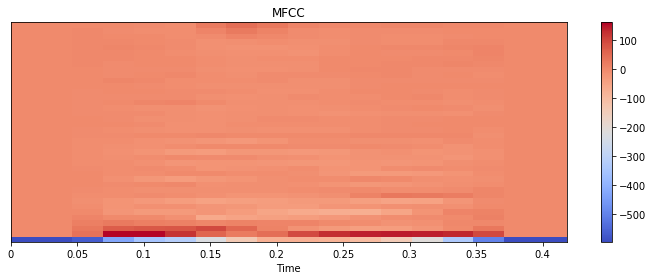

In [117]:
import matplotlib.pyplot as plt
from librosa.display import specshow
plt.figure(figsize=(10, 4))
specshow(test_mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

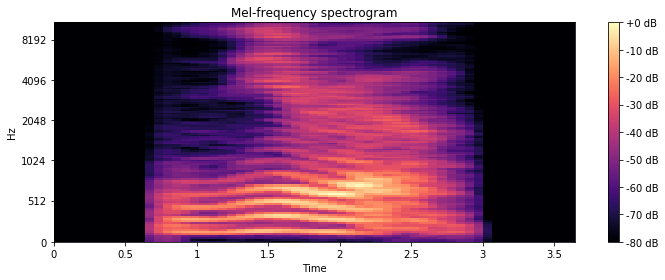

In [118]:
plt.figure(figsize=(10, 4))
test_spect = data_preparation.compute_spectrogram(test)
S_dB = librosa.power_to_db(test_spect, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=8000)
plt.title('Mel-frequency spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [120]:
import librosa
spectrogram = librosa.feature.melspectrogram(y=test,
                                                 sr=8000,
                                                 n_fft=1024,
                                                 hop_length=160)

In [121]:
spectrogram.shape

(128, 57)

In [122]:
spectrogram = librosa.feature.melspectrogram(y=test,
                                                 sr=8000)

In [123]:
spectrogram.shape

(128, 18)

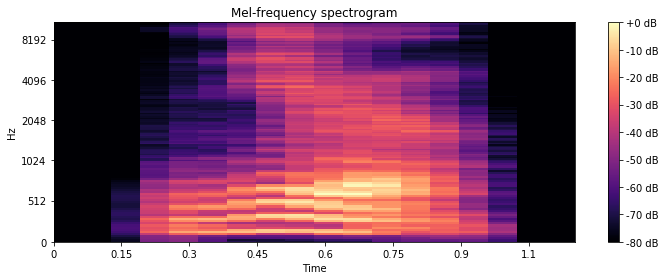

In [124]:
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=8000)
plt.title('Mel-frequency spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()